In [19]:
options(repr.plot.width = 14, repr.plot.height = 8)
options(warn=-1)

## PSA – маркер рака простаты

Возможно несколько вариантов
формулировки вопроса исследования:
Можно ли судить о концентрации
простат-специфичного антигена
по клиническим параметрам?
Коррелирует ли концентрация
простат-специфичного антигена
с клиническими параметрами?

Исследовано 97 пациентов, перенесших простатотомию.

**Зависимая перменная:** `lpsa` – логарифм концентрации простат-специфичного антигена

**Предикторы:**

  - `lcavol` – логарифм объема опухоли
  - `lweight` – логарифм веса
  - `age` – возраст пациента
  - `lbph` – логарифм степени доброкачественной гиперплазии
  - `svi` – поражение семенных пузырьков
  - `lcp` – логарифм меры поражения капсулы
  - `gleason` – оценка по шкале Глисона
  - `pgg45` – доля оценок 4 и 5 по шкале Глисона

Часть осмысления данных необходимо провести до построения модели
(разведочный анализ).
Часть – после того как модель построена (анализ валидности модели)

### 1. Дизайн сбора материала

Прежде всего, нужно осмыслить дизайн сбора материала, чтобы понять,
являются ли отдельные наблюдения взаимно-независимыми.
 - Нет ли скрытых группирующих (случайных) факторов
 - Нет ли временных и пространственных автокорреляций

### 2. Влиятельные наблюдания

Нужно проверить, нет ли отскакивающих значений.
Такие значения иногда могут быть следствием ошибки в исходных данных.

### 3. Распределение зависимой переменной

Простая линейная регрессия часто не подходит для моделирования некоторых
величин (например, для счетных данных).

### 4. Характер связи между зависимой переменной и предикторами

Связь между откликом и предикторами может выглядеть нелинейной.
Если выявляются нелинейные зависимости, то нужно правильно выбрать тип модели.
Не все зависимости можно моделировать с помощью простых
регрессионных моделей.

### 5. Независимость предикторов

Нужно проверить, нет ли взаимозависимости (коллинеарности http://bdemeshev.github.io/r_cycle/cycle_files/05_multicollinearity.html)
между предикторами.

### 6. Моделирование

### 7. Проверка валидности модели

Для моделей с нормальным распределением отклика:
- Если нарушений условий применимости не выявлено, то можно начать осмыслять результаты построения модели.
- Если выявлены нарушения условий применимости, то надо задуматься о том, верно ли подобран тип модели и все ли хорошо с данными.

Возвращаемся к пункту 1.
- Независимы ли наблюдения друг от друга (проверяем еще раз, т.к. речь идет уже не о дизайне, а о модели)
- Присутствует ли гетерогенность дисперсии
- Соответствует ли распределение остатков модели нормальному распределению

## Разведочный анализ

In [1]:
install.packages("https://cran.r-project.org/src/contrib/Archive/ElemStatLearn/ElemStatLearn_2015.6.26.2.tar.gz", 
                 repos = NULL, type="source")

### Читаем данные

In [2]:
library(ElemStatLearn)
data("prostate")
prost <- prostate[, -10]

In [3]:
head(prost)

,lcavol,lweight,age,lbph,svi,lcp,gleason,pgg45,lpsa
,<dbl>,<dbl>,<int>,<dbl>,<int>,<dbl>,<int>,<int>,<dbl>
1,-0.5798185,2.769459,50,-1.386294,0,-1.386294,6,0,-0.4307829
2,-0.9942523,3.319626,58,-1.386294,0,-1.386294,6,0,-0.1625189
3,-0.5108256,2.691243,74,-1.386294,0,-1.386294,7,20,-0.1625189
4,-1.2039728,3.282789,58,-1.386294,0,-1.386294,6,0,-0.1625189
5,0.7514161,3.432373,62,-1.386294,0,-1.386294,6,0,0.3715636
6,-1.0498221,3.228826,50,-1.386294,0,-1.386294,6,0,0.7654678


### Смотрим на структуру данных

In [4]:
str(prost)

'data.frame':	97 obs. of  9 variables:
 $ lcavol : num  -0.58 -0.994 -0.511 -1.204 0.751 ...
 $ lweight: num  2.77 3.32 2.69 3.28 3.43 ...
 $ age    : int  50 58 74 58 62 50 64 58 47 63 ...
 $ lbph   : num  -1.39 -1.39 -1.39 -1.39 -1.39 ...
 $ svi    : int  0 0 0 0 0 0 0 0 0 0 ...
 $ lcp    : num  -1.39 -1.39 -1.39 -1.39 -1.39 ...
 $ gleason: int  6 6 7 6 6 6 6 6 6 6 ...
 $ pgg45  : int  0 0 20 0 0 0 0 0 0 0 ...
 $ lpsa   : num  -0.431 -0.163 -0.163 -0.163 0.372 ...


### Есть ли пропущенные значения?

In [5]:
colSums(is.na(prost))

lcavol lweight     age    lbph     svi     lcp gleason   pgg45    lpsa 
      0       0       0       0       0       0       0       0       0

### Ищем отскоки

Отскоки (выбросы, outliers) — наблюдения, которые имеют более высокие
(или низкие) значения относительно большинства других наблюдений.
Для визуального выявления отскакивающих значений используют два метода:
- Построение боксплотов (Box-whiskers plot)
- Построение точечных диаграмм Кливленда (Cleveland dotplot)

In [6]:
library(tidyr) # пакет для tidy данных
prost_long <- prost %>% gather() # переводим в длинный формат
head(prost_long)

,key,value
,<chr>,<dbl>
1,lcavol,-0.5798185
2,lcavol,-0.9942523
3,lcavol,-0.5108256
4,lcavol,-1.2039728
5,lcavol,0.7514161
6,lcavol,-1.0498221


### Боксплоты

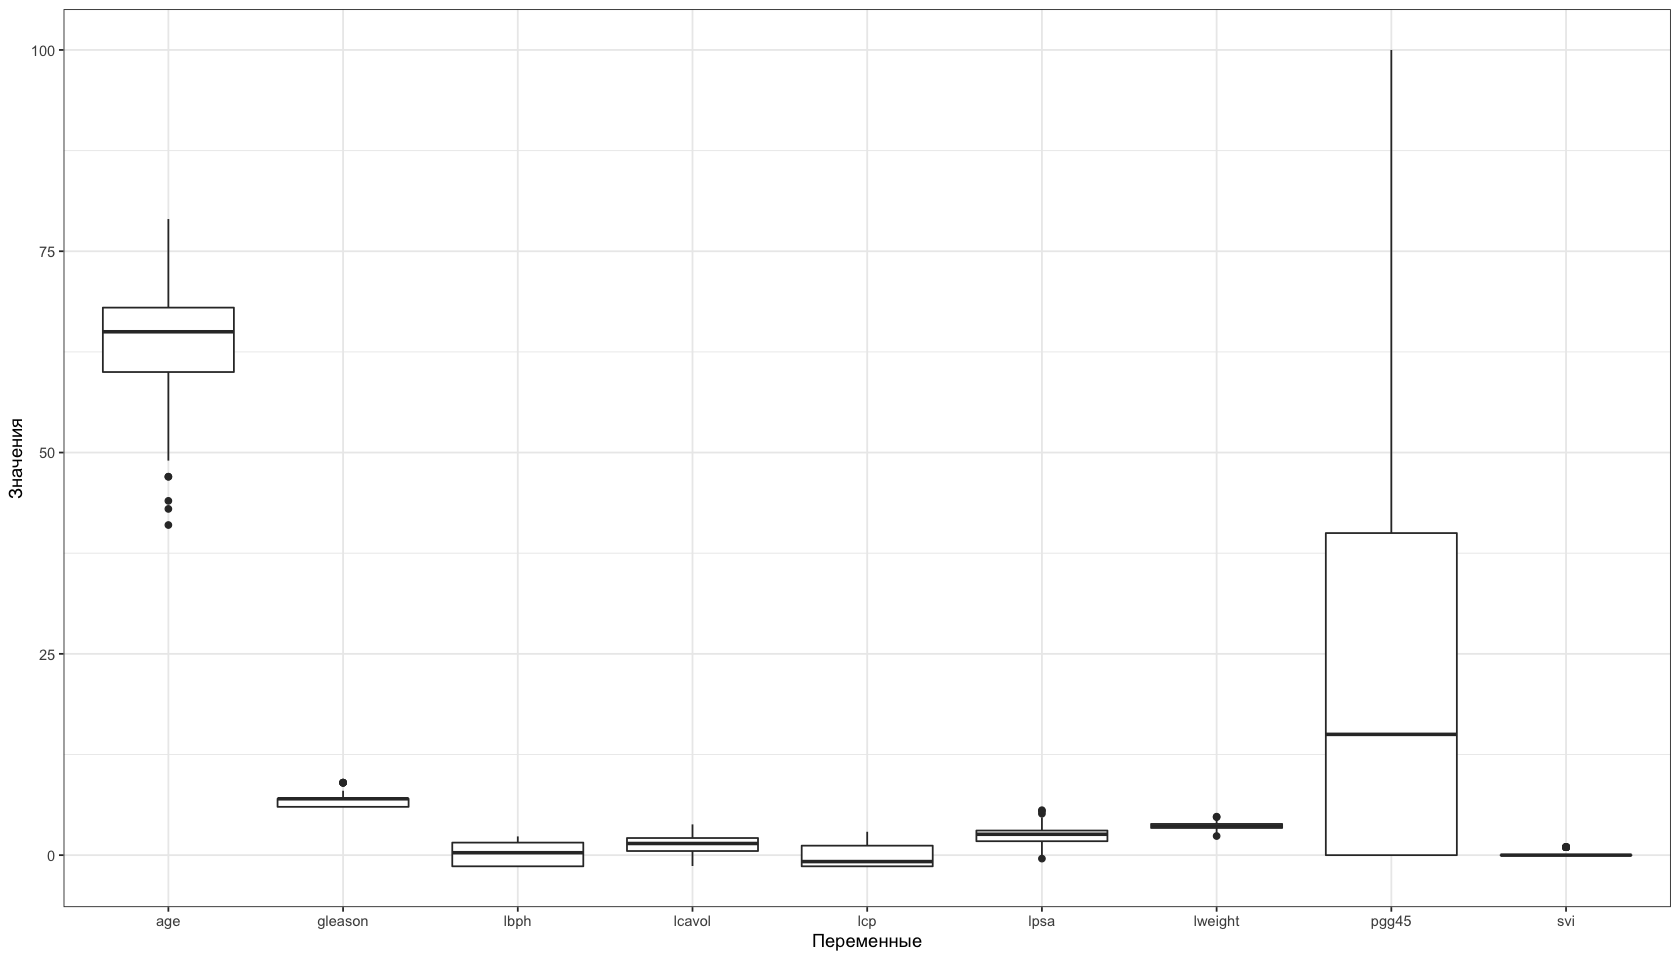

In [80]:
library(ggplot2)
theme_set(theme_bw())
ggplot(prost_long, aes(x = key, y = value)) +
 geom_boxplot() +
 labs(x = 'Переменные', y = 'Значения')

Очень разные шкалы признаков. Может понадобиться стандартизация значений.

$$z_i = \dfrac{x_i - \bar{x}}{s}$$

### Боксплоты после стандартизации

In [9]:
library(dplyr) # пакет для предобработки данных
prost_long <- prost %>% gather() %>% 
  group_by(key) %>% 
  mutate (scale_value = scale(value))

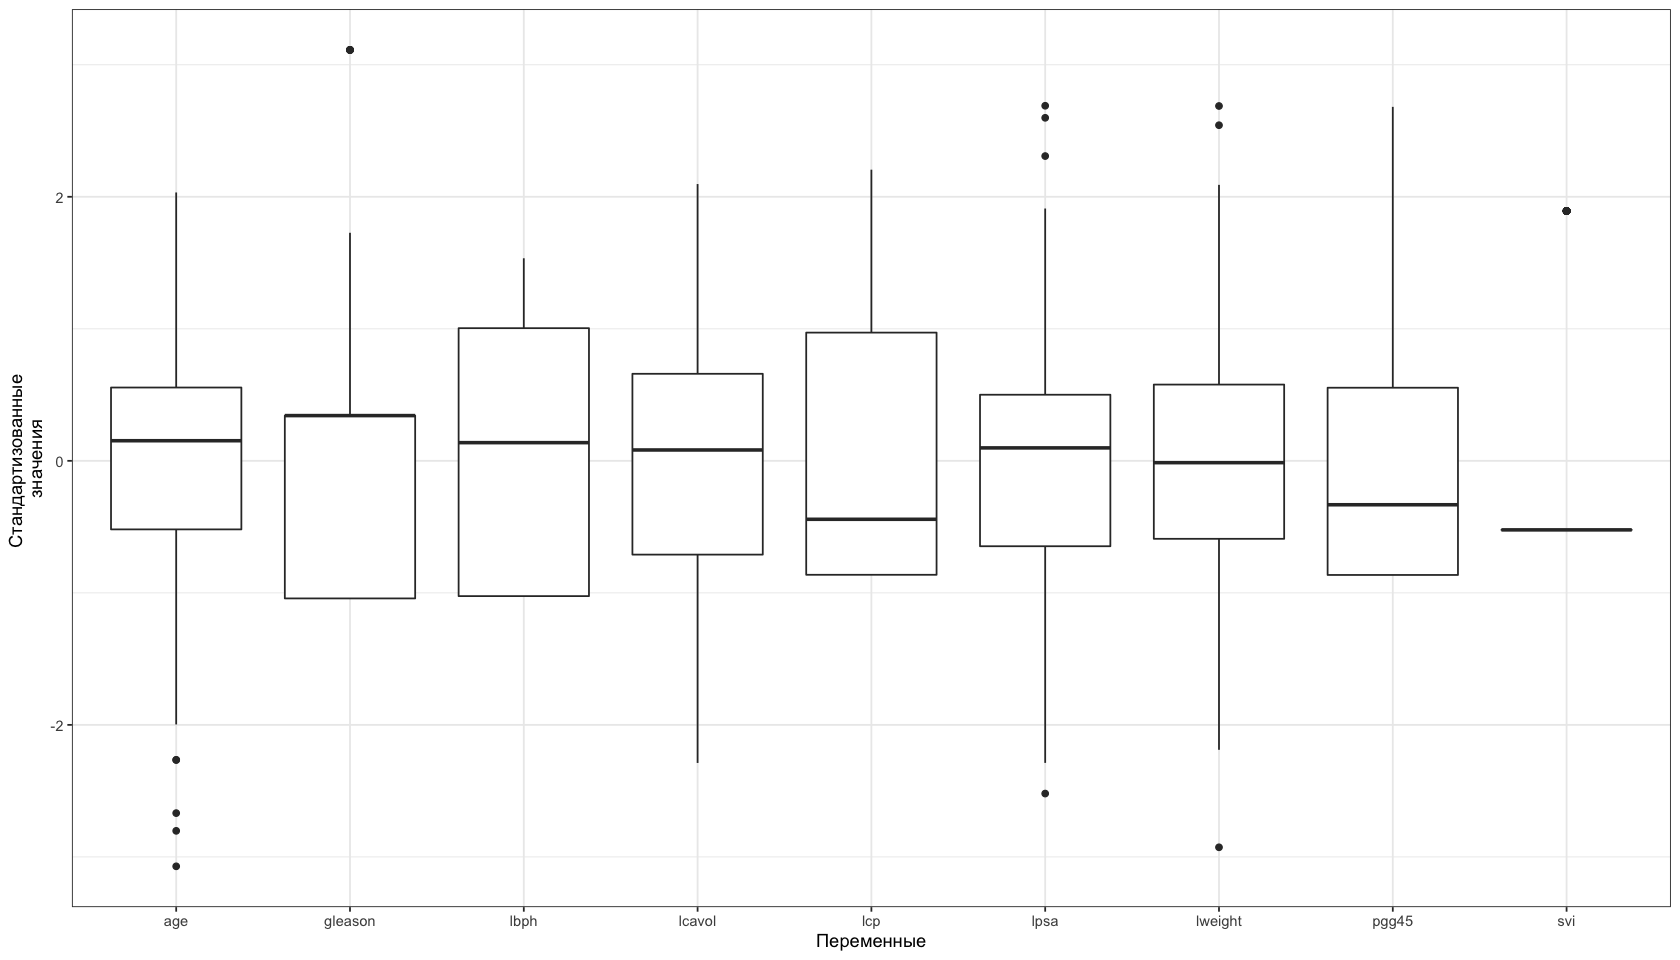

In [66]:
ggplot(prost_long, aes(x = key, y = scale_value)) +
  geom_boxplot() +
  labs(x = 'Переменные', y = 'Стандартизованные \nзначения')

### Точечные диаграммы Кливленда

Удобнее предыдущего метода тем, что становятся видны явные отскоки.

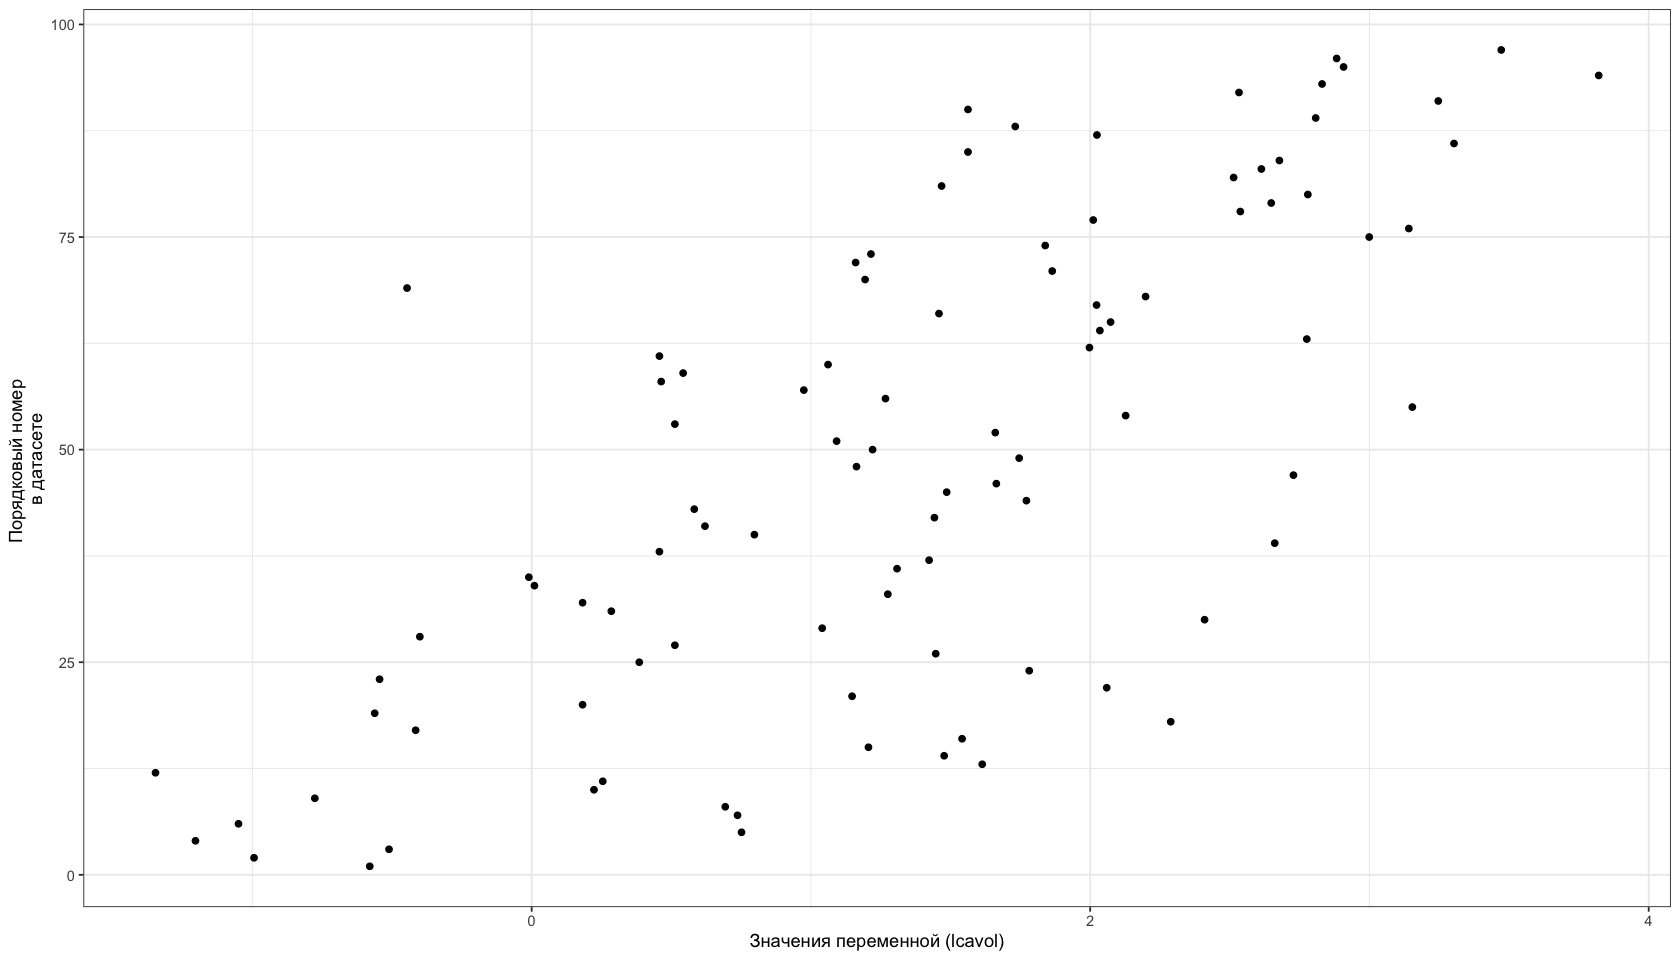

In [67]:
ggplot(prost, aes(y = 1:nrow(prost), x = lcavol)) + geom_point() +
  labs(y = 'Порядковый номер \nв датасете', x = 'Значения переменной (lcavol)')

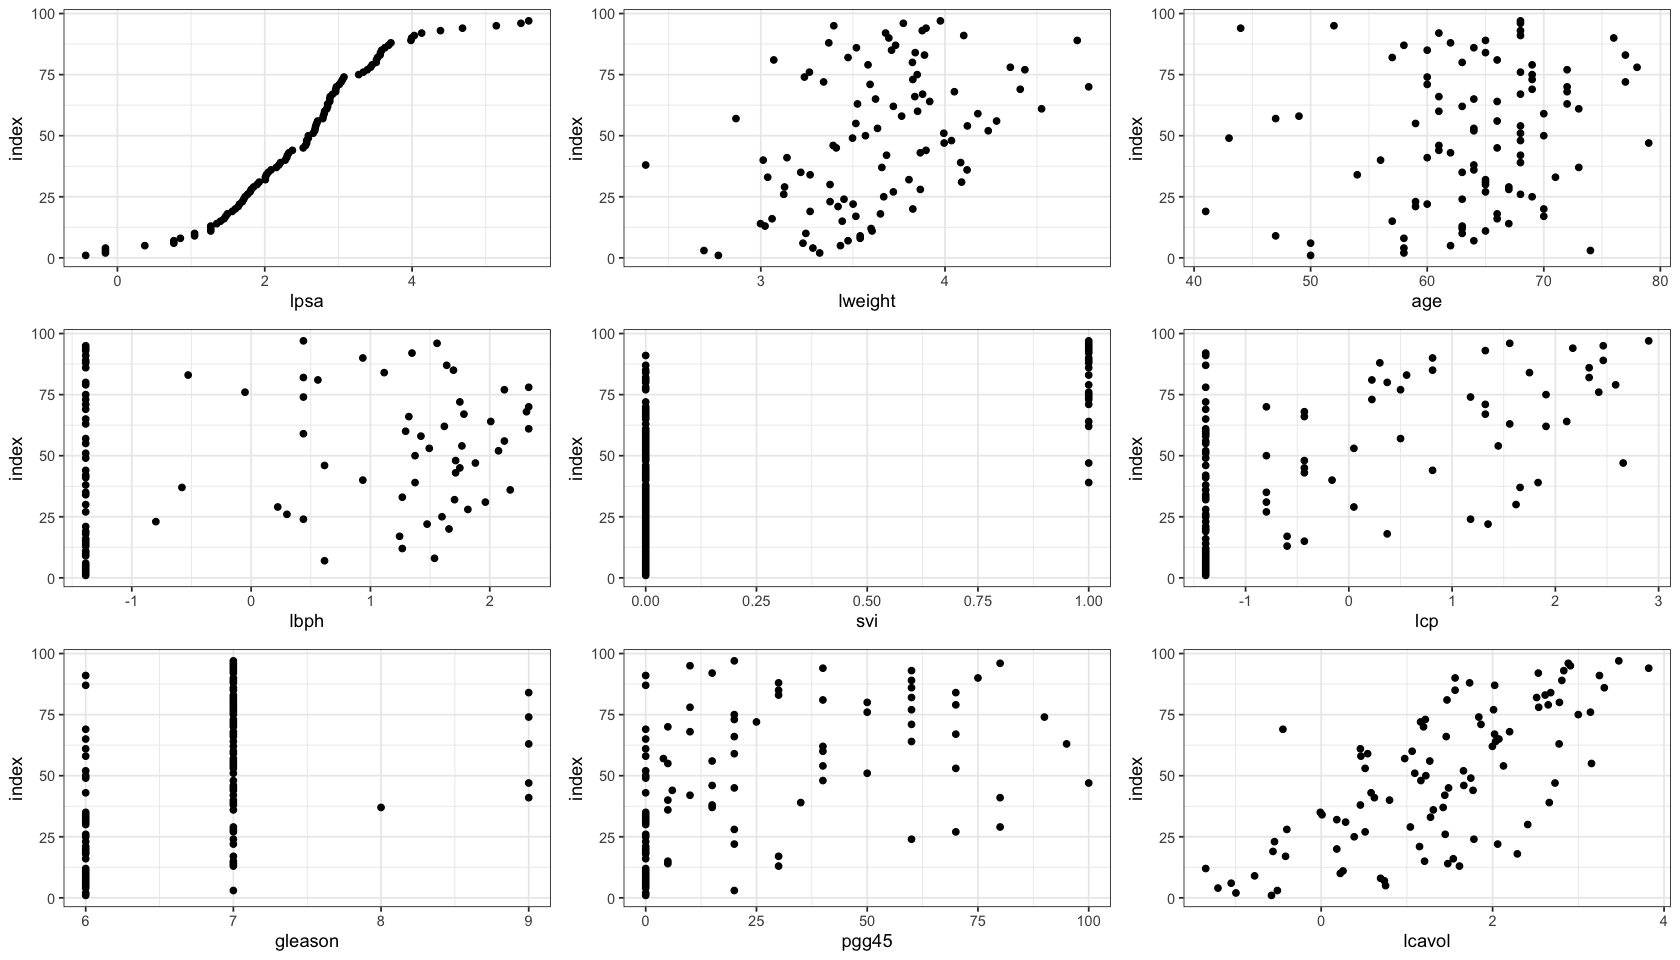

In [20]:
gg_dot <- ggplot(prost, aes(y = 1:nrow(prost))) + geom_point() + ylab('index')
Pl1 <- gg_dot + aes(x = lpsa)
Pl2 <- gg_dot + aes(x = lweight)
Pl3 <- gg_dot + aes(x = age)
Pl4 <- gg_dot + aes(x = lbph)
Pl5 <- gg_dot + aes(x = svi)
Pl6 <- gg_dot + aes(x = lcp)
Pl7 <- gg_dot + aes(x = gleason)
Pl8 <- gg_dot + aes(x = pgg45)
Pl9 <- gg_dot + aes(x = lcavol)

library(cowplot) # пакет для группировки графиков
theme_set(theme_bw())
plot_grid(Pl1, Pl2, Pl3, Pl4, Pl5, Pl6,
 Pl7, Pl8, Pl9, ncol = 3, nrow = 3)

### «Странные» предикторы

Это дискретные предикторы, но закодированные числами.

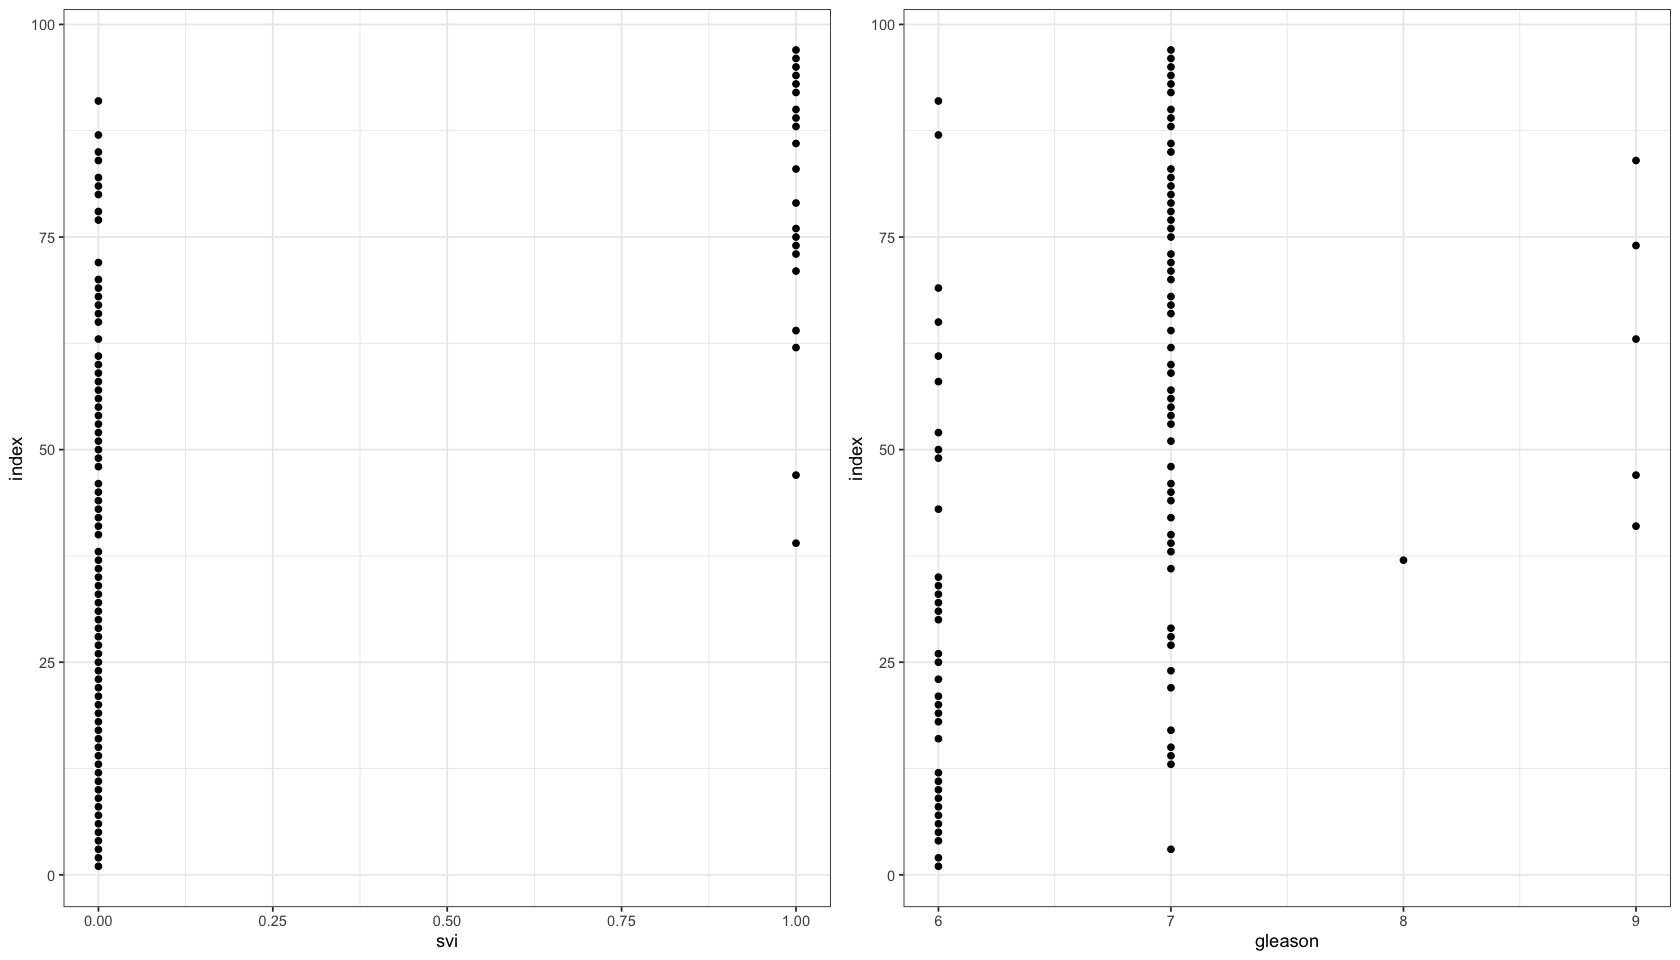

In [18]:
plot_grid(Pl5, Pl7, ncol = 2)

### Характер связи между зависимой переменной и предикторами

`geom_smooth()` using method = 'loess' and formula 'y ~ x'

`geom_smooth()` using method = 'loess' and formula 'y ~ x'

`geom_smooth()` using method = 'loess' and formula 'y ~ x'

`geom_smooth()` using method = 'loess' and formula 'y ~ x'

`geom_smooth()` using method = 'loess' and formula 'y ~ x'

`geom_smooth()` using method = 'loess' and formula 'y ~ x'



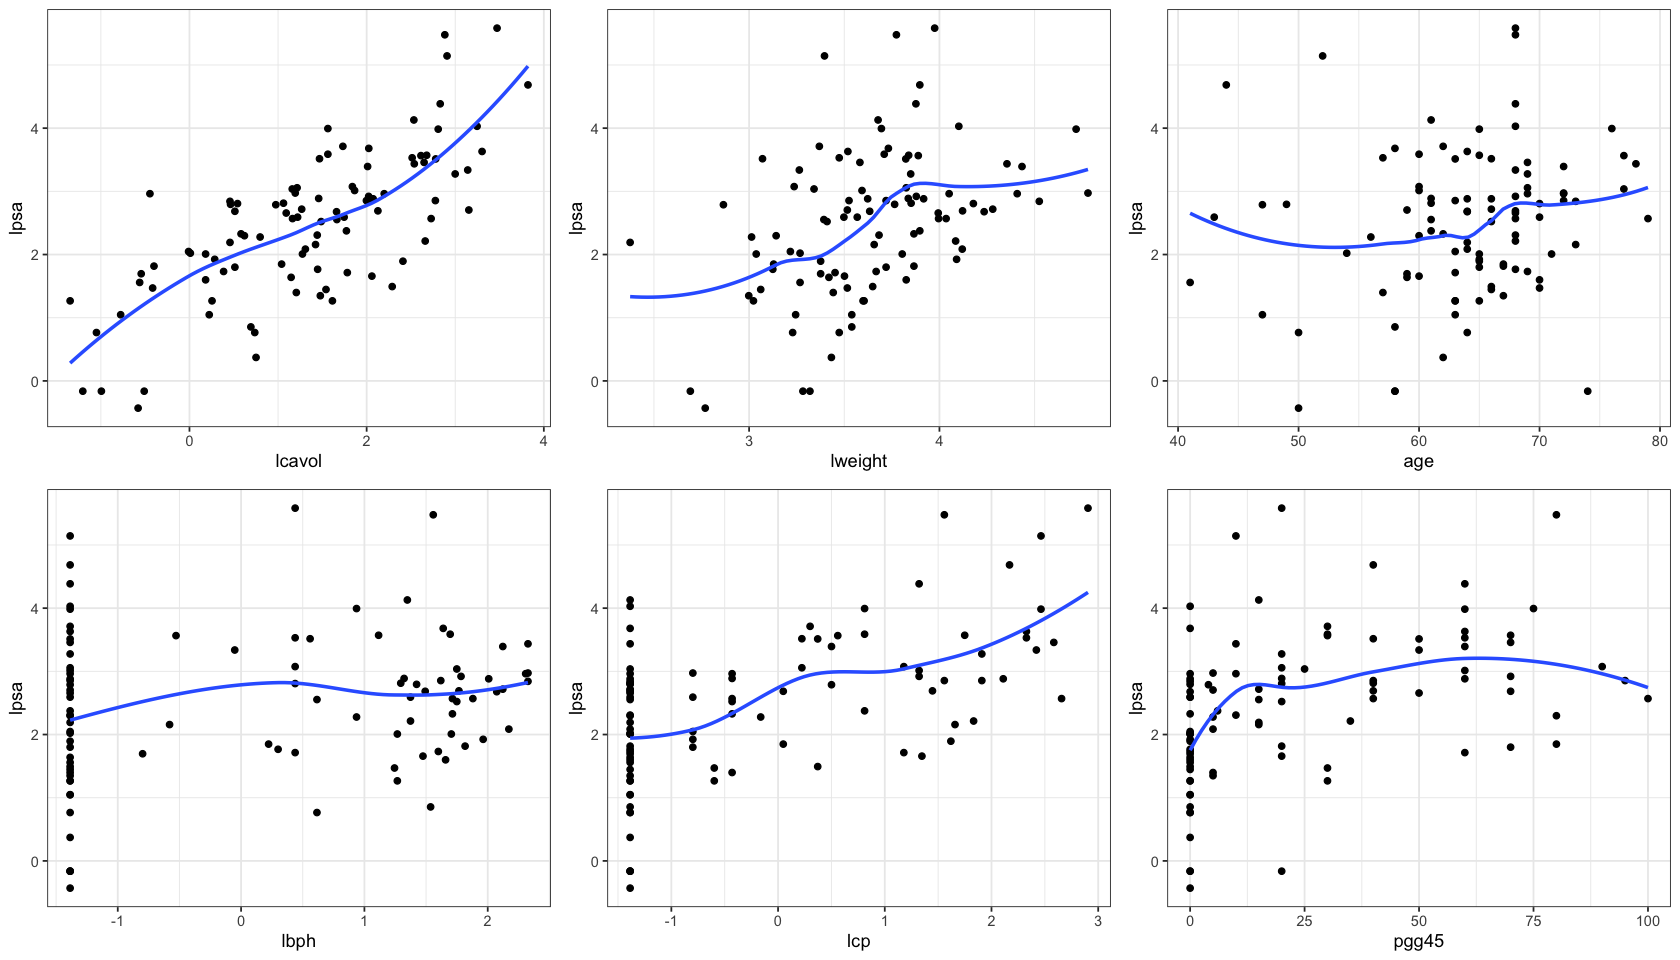

In [22]:
gg_cor <- ggplot(prost, aes(y = lpsa)) + 
 geom_point() + 
 geom_smooth(se = FALSE)
Pl1 <- gg_cor + aes(x = lcavol)
Pl2 <- gg_cor + aes(x = lweight)
Pl3 <- gg_cor + aes(x = age)
Pl4 <- gg_cor + aes(x = lbph)
Pl6 <- gg_cor + aes(x = lcp)
Pl8 <- gg_cor + aes(x = pgg45)
plot_grid(Pl1, Pl2, Pl3, Pl4, Pl6, Pl8, ncol = 3)

## Модель множественной линейной регрессии и ее интерпретация

Мы хотим выяснить: есть ли связь между переменной `lpsa` и прочими переменными. Можно ли ответить на вопрос, построив
матрицу корреляций?

In [23]:
round(cor(prost[, -c(5, 7)]), 2) # без дискретных переменных svi и gleason

,lcavol,lweight,age,lbph,lcp,pgg45,lpsa
lcavol,1.00,0.28,0.22,0.03,0.68,0.43,0.73
lweight,0.28,1.00,0.35,0.44,0.16,0.11,0.43
age,0.22,0.35,1.00,0.35,0.13,0.28,0.17
lbph,0.03,0.44,0.35,1.00,-0.01,0.08,0.18
lcp,0.68,0.16,0.13,-0.01,1.00,0.63,0.55
pgg45,0.43,0.11,0.28,0.08,0.63,1.00,0.42
lpsa,0.73,0.43,0.17,0.18,0.55,0.42,1.00


- Обычная корреляция не учитывает, что взаимосвязь между переменными может находиться под контролем других переменых и их взаимодействий.
- Множественные тесты. При тестировании значимости множества коэффициентов корреляции нужно вводить поправку для уровня значимости.

Все взаимосвязи лучше тестировать в одном анализе

### Нам нужно построить множественную регрессионную модель

$$y_i = b_0 + b_1x_{1i} + b_2x_{2i} + b_3x_{3i} + \ldots + b_{p−1}x_{p−1i} + e_i$$

- $y_i$ – значение зависимой переменной для $i$-того наблюдения
- $b_0$ – свободный член (intercept)
- $b_1$ – частный угловой коэффициент для зависимости $y$ от $x_1$. Показывает, на сколько единиц изменяется $y$ при изменении $x_1$ на одну единицу, при условии, что все остальные предикторы не изменяются.
- $b_2, b_3, …, b_p$ – аналогично
- $e_i$ – варьирование $y$, не объясняемое данной моделью

### Геометрическая интерпретация простой линейной модели

Если предиктор один, получается линия регрессии. $y_i = b_0 + b_1x_i + e_i$

Если два предиктора, то получится плоскость в трехмерном пространстве. $y_i = b_0 + b_1x_i + b_2x_{2i} + e_i$

Если много предикторов – плоскость в p-мерном пространстве, оси которого образованы значениями предикторов.
$y_i = b_0 + b_1x_{1i} + b_2x_{2i} + b_3x_{3i} + \ldots + b_{p−1}x_{p−1i} + e_i$

### Множественная линейная модель в R

In [25]:
M_prost_1 <- lm(lpsa ~ lcavol + lweight + age + lbph + lcp + pgg45, data = prost)

Если бы в датасете были только нужные переменные, мы могли бы записать модель иначе.

Символ . (точка) в формуле модели обозначает все доступные
переменные из данных в аргументе data.

```r 
my_predictors <- !colnames(prost) %in% c('svi', 'gleason')
prost3 <- prost[, my_predictors]
M_prost_1_all <- lm(lpsa ~ . , data = prost3)```

**Теперь мы можем записать уравнение множественной регрессии**

$$\hat{y}_i = b_0 + b_1x_{1i} + b_2x_{2i} + b_3x_{3i} + b_4x_{4i} + b_5x_{5i} + b_6x_{6i}$$

In [27]:
print(coef(M_prost_1))

 (Intercept)       lcavol      lweight          age         lbph          lcp 
 0.356987967  0.604601933  0.668864691 -0.019939889  0.069018686  0.012590955 
       pgg45 
 0.006017749 


$\hat{lpsa} = 0.834 + 0.628\cdot lcavol + 0.496 \cdot lweight − 0.018 \cdot age + 0.079 \cdot lbph + 0.014 \cdot lcp + 0.006 \cdot pgg45$

### Множественная регрессия в матричном виде

Аналогично простой регрессии $Y = Xb + e$

Отличие лишь в форме модельной матрицы

### Модельная матрица в множественной регрессии

In [28]:
X <- model.matrix(M_prost_1)
head(X)

,(Intercept),lcavol,lweight,age,lbph,lcp,pgg45
1,1,-0.5798185,2.769459,50,-1.386294,-1.386294,0
2,1,-0.9942523,3.319626,58,-1.386294,-1.386294,0
3,1,-0.5108256,2.691243,74,-1.386294,-1.386294,20
4,1,-1.2039728,3.282789,58,-1.386294,-1.386294,0
5,1,0.7514161,3.432373,62,-1.386294,-1.386294,0
6,1,-1.0498221,3.228826,50,-1.386294,-1.386294,0


### Условия применимости линейных моделей

- Линейная связь
- Независимость наблюдений
- Нормальное распределение остатков
- Гомогенность дисперсий остатков
- Отсутствие коллинеарности предикторов (для множественной регрессии)

### Мультиколлинеарность

__Мультиколлинеарность__ – наличие линейной зависимости между предикторами
регрессионной модели.

Косвенные признаки мультиколлинеарности

- Большие ошибки оценок параметров
- Большинство параметров модели недостоверно отличается от нуля, но F-критерий говорит, что вся модель значима

Проверка на мультиколлинеарность

- Фактор инфляции дисперсии (Variance inflation factor, VIF)

### Как рассчитывается VIF

Мы должны оценить, какую долю изменчивости конкретного предиктора могут объяснить другие предикторы (т.е. насколько предикторы связаны друг с другом)

Для каждого предиктора:

 1. Строим регрессионную модель данного предиктора от всех остальных
 2. Находим $R^2$ модели
 3. Вычисляем фактор инфляции дисперсии $VIF = \dfrac{1}{1 - R^2}$

### Чем опасна мультиколлинеарность

- Стандартные ошибки оценок параметров будут увеличены в $\sqrt{VIF}$ раз
- Уровень значимости (p-value) будет выше
- Меньше шансов заметить влияние предиктора
- Оценки коэффициентов нестабильны – они даже могут менять знак при небольших изменениях модели или исходных данных.

### Что делать, если мультиколлинеарность выявлена

- Можно последовательно удалить из модели избыточные предикторы с VIF > 3 (иногда VIF > 2).
  1. подбираем модель
  2. считаем VIF
  3. удаляем предиктор с самым большим VIF
  4. повторяем 1-3, пока VIF не станет меньше 2
- Можно заменить исходные предикторы новыми независимыми друг от друга переменными, полученными с помощью метода главных компонент.

### Проверяем на мультиколлинеарность построенную модель

Функция `vif()` из пакета `car`

In [34]:
library(car)
print(vif(M_prost_1))

  lcavol  lweight      age     lbph      lcp    pgg45 
1.995224 1.421809 1.322923 1.349793 2.556815 1.798443 


В нашей модели сильной мультиколлинеарности нет.
Однако возможно, что `lcp` – избыточный предиктор.

### Удалим из модели избыточный предиктор

In [35]:
M_prost_2 <- update(M_prost_1, ~ . - lcp)
print(vif(M_prost_2))

  lcavol  lweight      age     lbph    pgg45 
1.355567 1.419959 1.294151 1.347458 1.295769 


Теперь мультиколлинеарности нет.

Осталось пройти другие этапы проверки валидности модели –
проверить остальные условия применимости.

### Данные для анализа остатков

In [36]:
M_prost_2_diag <- fortify(M_prost_2)
head(M_prost_2_diag)

,lpsa,lcavol,lweight,age,lbph,pgg45,.hat,.sigma,.cooksd,.fitted,.resid,.stdresid
,<dbl>,<dbl>,<dbl>,<int>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,-0.4307829,-0.5798185,2.769459,50,-1.386294,0,0.07778772,0.7184198,4.004697e-02,0.7457957,-1.1765785658,-1.687797635
2,-0.1625189,-0.9942523,3.319626,58,-1.386294,0,0.06242345,0.7238826,1.667806e-02,0.6992016,-0.8617204576,-1.225964593
3,-0.1625189,-0.5108256,2.691243,74,-1.386294,20,0.13934553,0.7273576,1.731500e-02,0.3769349,-0.5394537630,-0.801040928
4,-0.1625189,-1.2039728,3.282789,58,-1.386294,0,0.06994664,0.7258141,1.284475e-02,0.5461576,-0.7086764554,-1.012299366
5,0.3715636,0.7514161,3.432373,62,-1.386294,0,0.02931276,0.7146059,1.903538e-02,1.7624525,-1.3908889164,-1.944767463
6,0.7654678,-1.0498221,3.228826,50,-1.386294,0,0.07971433,0.7299356,5.089848e-09,0.7658813,-0.0004134925,-0.000593774


### График расстояния Кука

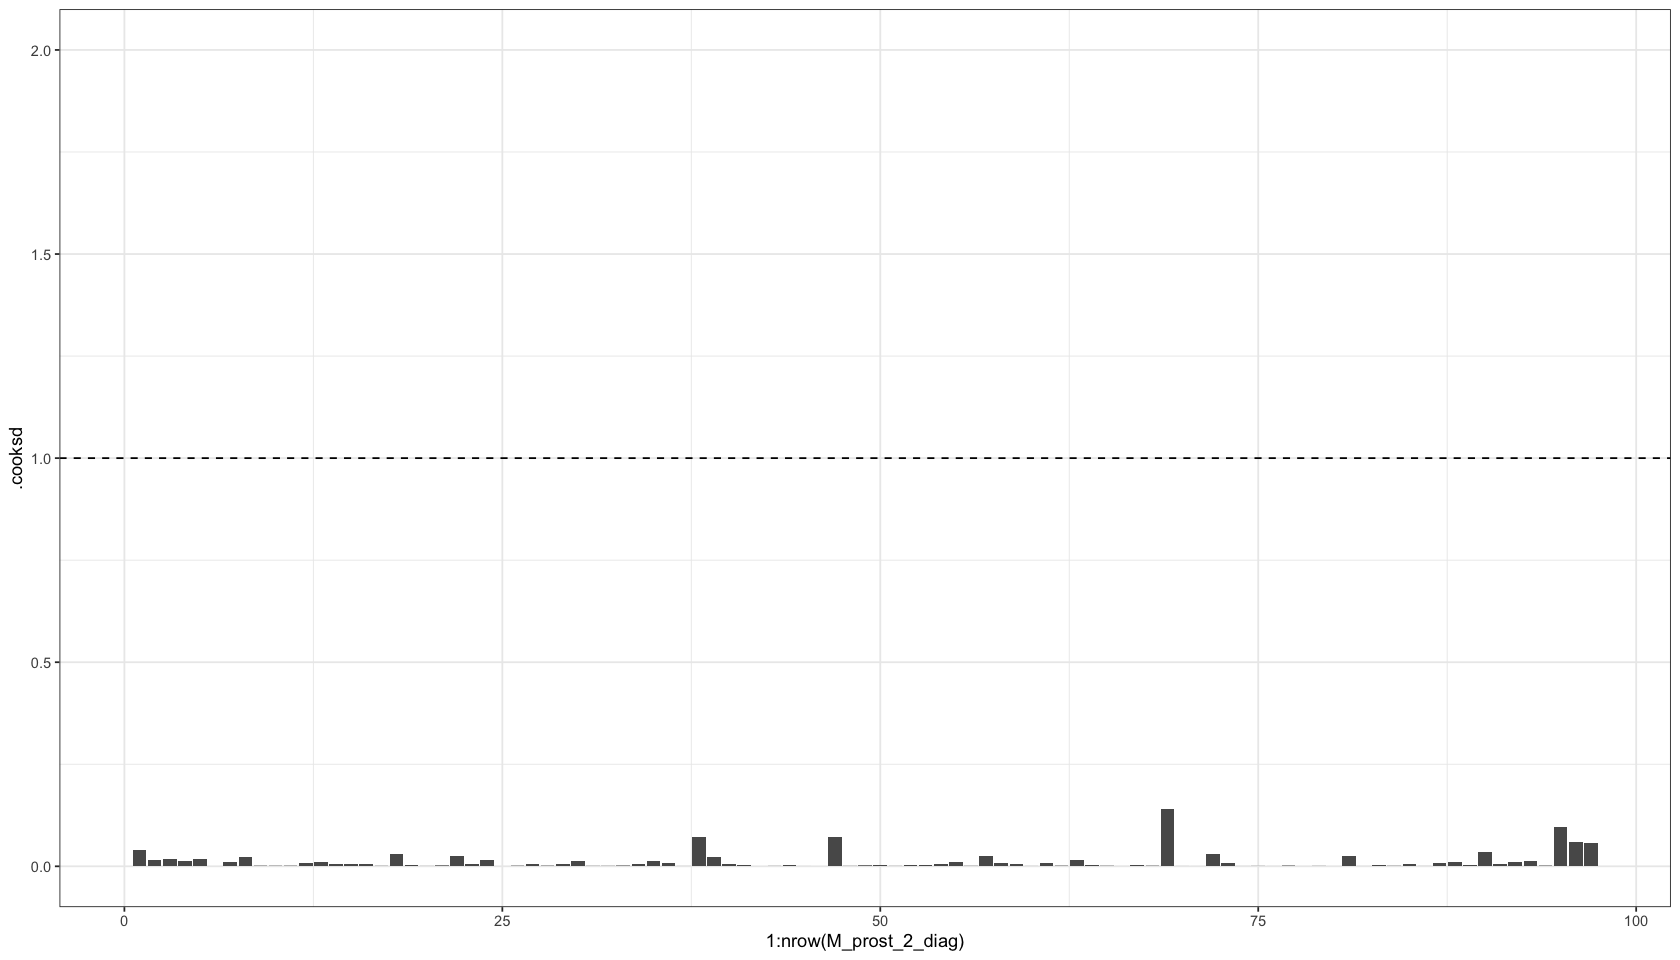

In [37]:
ggplot(M_prost_2_diag, aes(x = 1:nrow(M_prost_2_diag), y = .cooksd)) +
 geom_bar(stat = 'identity') + coord_cartesian(ylim = c(0, 2)) +
 geom_hline(yintercept = 1, linetype = 2)

Влиятельных наблюдений нет.

### График остатков от предсказанных значений

`geom_smooth()` using method = 'loess' and formula 'y ~ x'



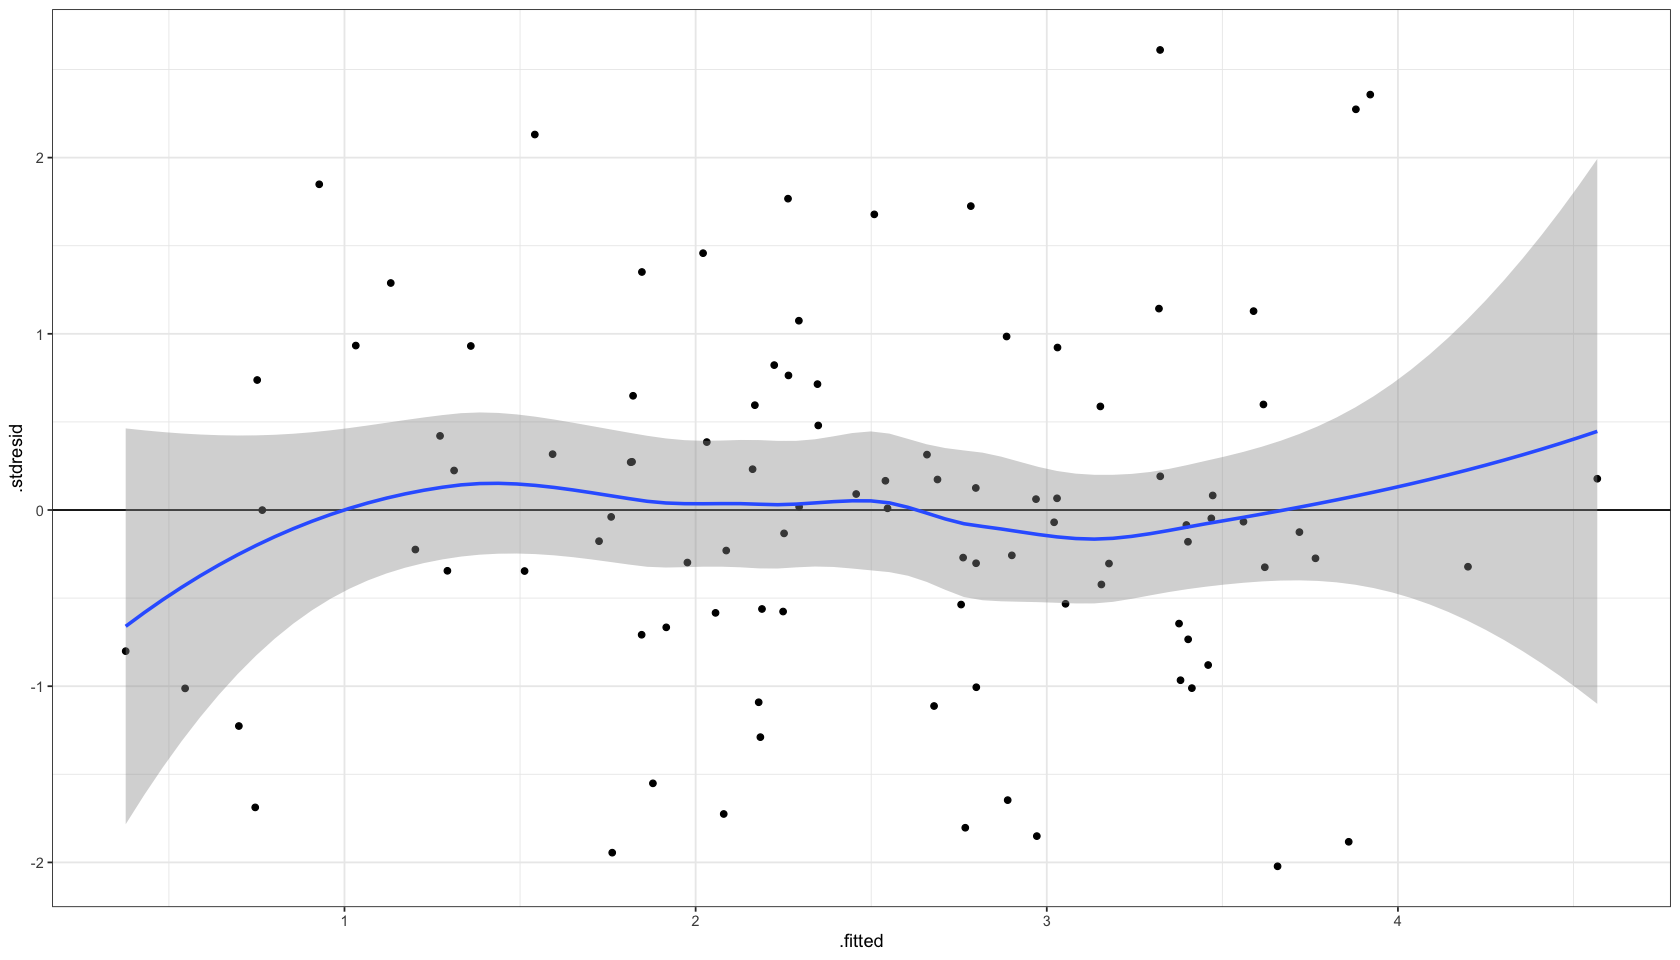

In [38]:
gg_resid <- ggplot(data = M_prost_2_diag, aes(x = .fitted, y = .stdresid)) +
 geom_point() + geom_hline(yintercept = 0) + geom_smooth()
gg_resid

Выбросов нет. Гетерогенность дисперсии не выявляется.

### Графики зависимости остатков от предикторов в модели

`geom_smooth()` using method = 'loess' and formula 'y ~ x'

`geom_smooth()` using method = 'loess' and formula 'y ~ x'

`geom_smooth()` using method = 'loess' and formula 'y ~ x'

`geom_smooth()` using method = 'loess' and formula 'y ~ x'

`geom_smooth()` using method = 'loess' and formula 'y ~ x'



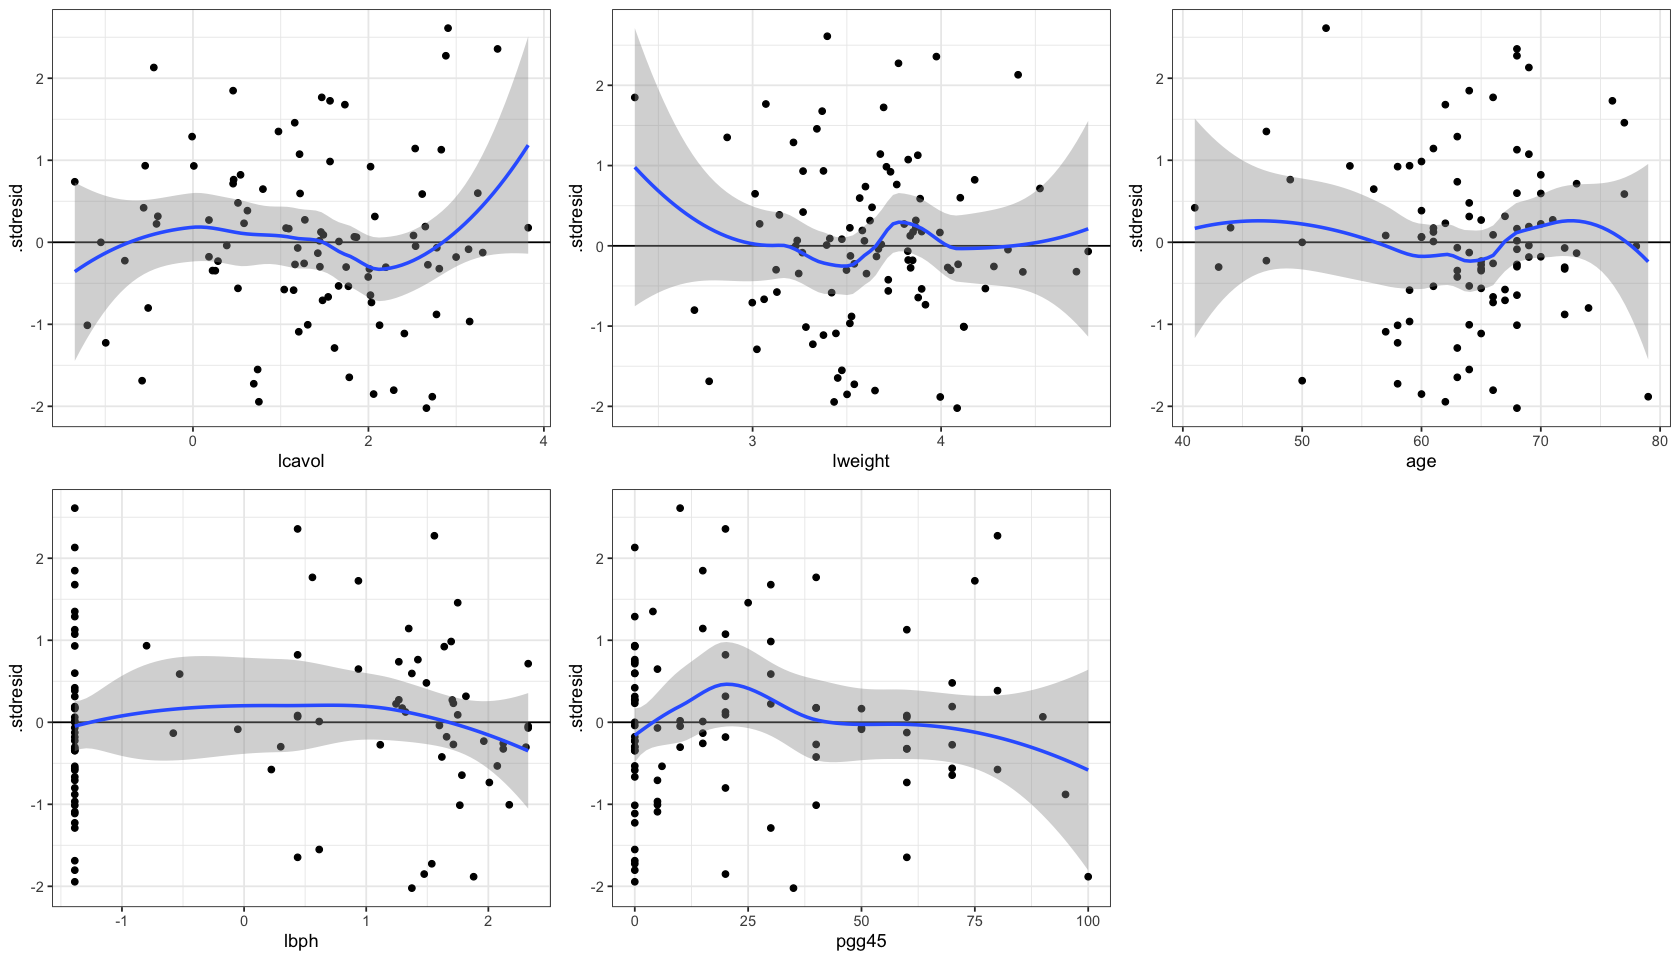

In [39]:
res_1 <- gg_resid + aes(x = lcavol)
res_2 <- gg_resid + aes(x = lweight)
res_3 <- gg_resid + aes(x = age)
res_4 <- gg_resid + aes(x = lbph)
res_5 <- gg_resid + aes(x = pgg45)
plot_grid(res_1, res_2, res_3, res_4,
 res_5, ncol = 3)

### Графики остатков от переменных, не включенных в модель

`geom_smooth()` using method = 'loess' and formula 'y ~ x'



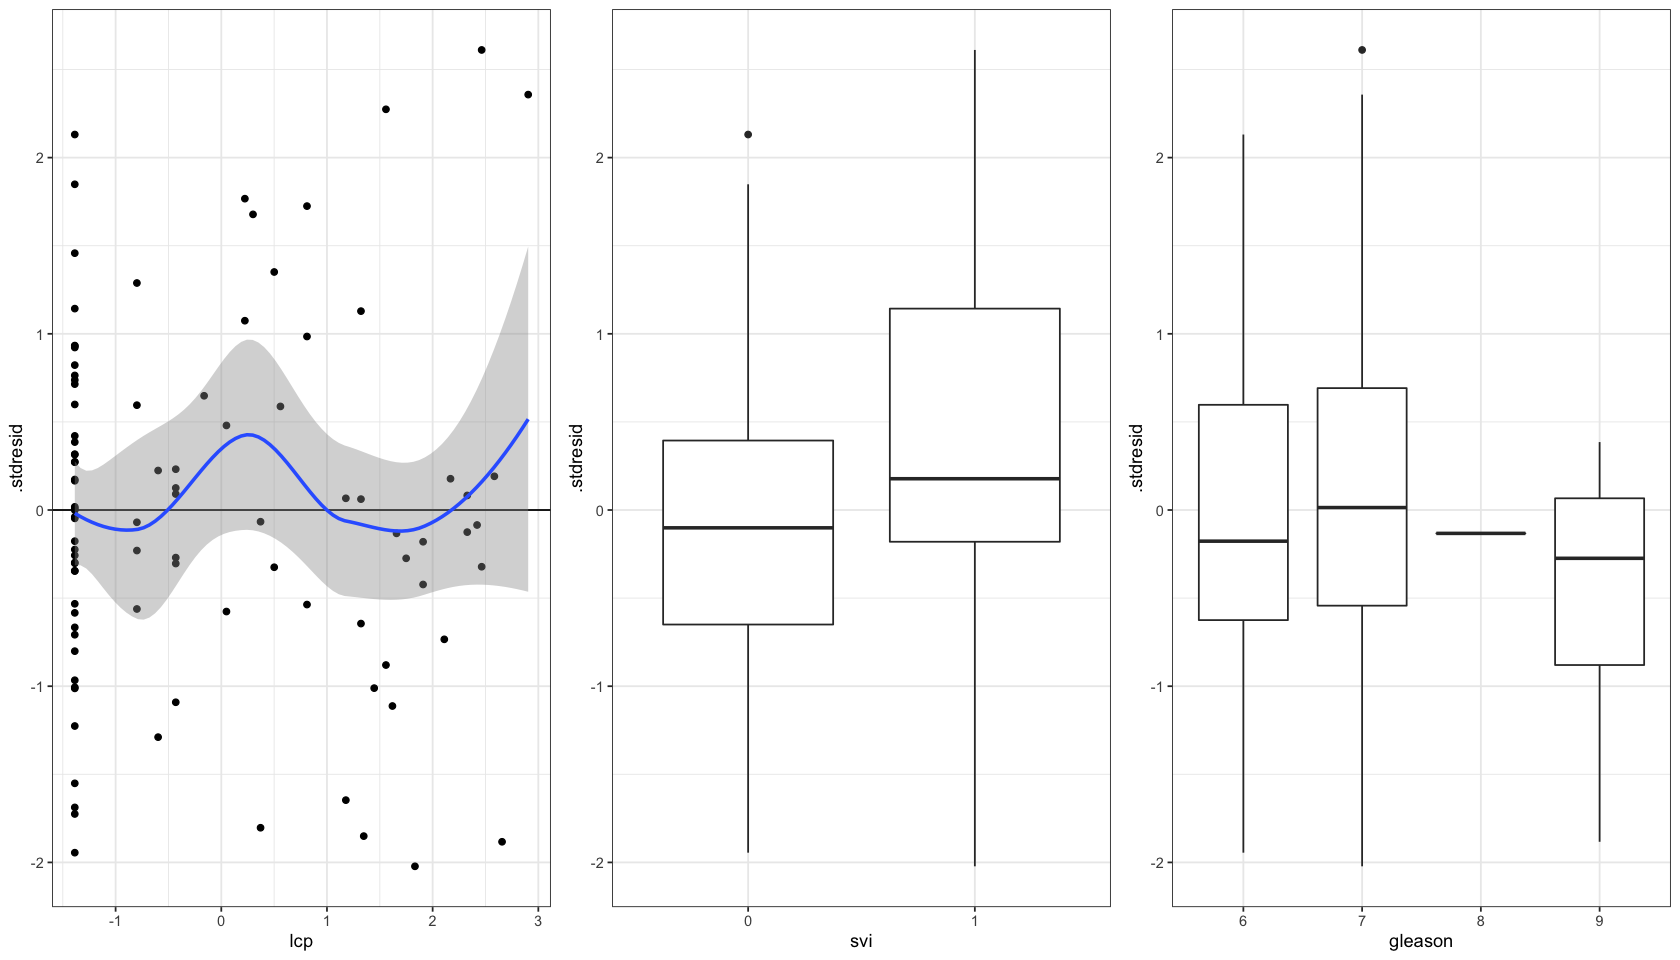

In [40]:
res_6 <- gg_resid + aes(x = prost$lcp) + labs(x = 'lcp')
res_7 <- ggplot(M_prost_2_diag, aes(y = .stdresid)) +
 geom_boxplot(aes(x = factor(prost$svi))) + labs(x = 'svi')
res_8 <- ggplot(M_prost_2_diag, aes(y = .stdresid)) +
 geom_boxplot(aes(x = factor(prost$gleason))) + labs(x = 'gleason')
plot_grid(res_6, res_7, res_8, nrow = 1)

Нелинейный паттерн на графике с `lcp`. Величина остатков зависит от обеих дискретных
переменных – вероятно, их было бы правильно добавить в модель.

### Квантильный график остатков

[1] 95 97

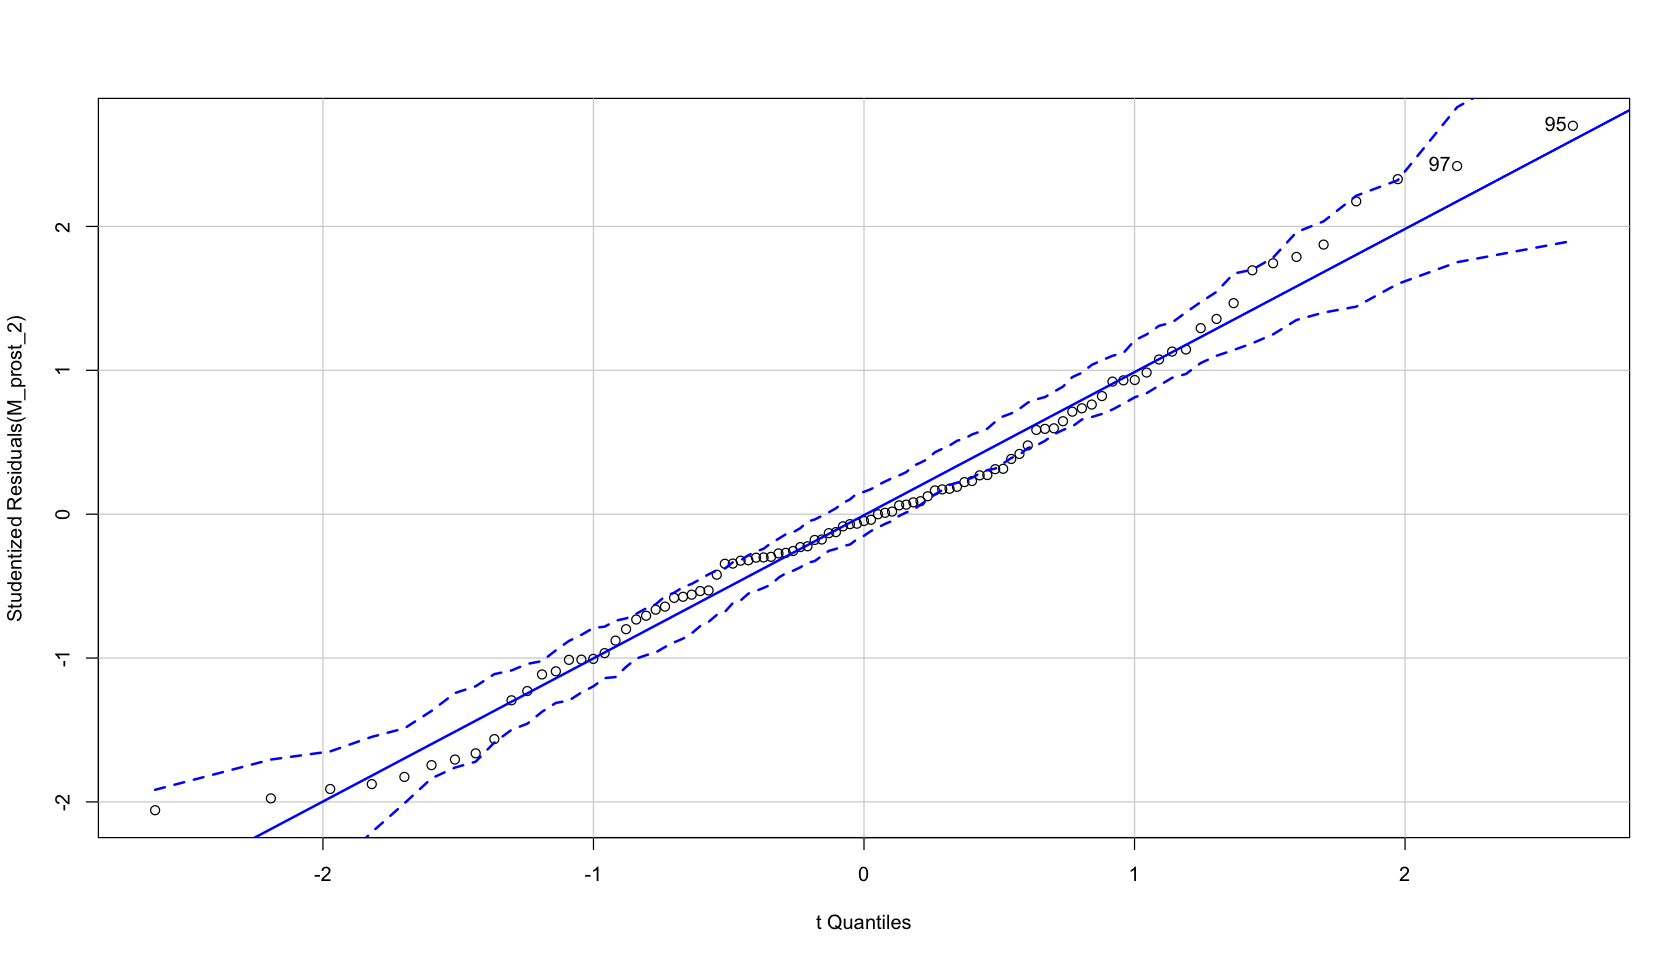

In [41]:
qqPlot(M_prost_2) # qqPlot из пакета car

Отклонения от нормального распределения остатков не выявляются.

## Взаимодействия предикторов

Вопрос о включении в модель взаимодействия предикторов совсем непростой.

Существует несколько подходов:

 1. Не включать взаимодействия в модель. Но если при валидации модели в остатках появляется явный паттерн, то это может быть следствием наличия взаимодействия предикторов.
 2. Основываясь на априорных знаниях свойств объектов, включить только те взаимодействия, которые имеют определенный смысл и могут быть интерпретированы.
 3. Включить в модель взаимодействия с наиболее важными переменными (теми, ради которых была затеяна работа).
 4. Включать в модель все взаимодействия, потом пошагово выбросить недостоверные (Model selection - об этом позднее).

Включать в анализ и обсуждать все взаимодействия «дорого» (неудобно), а иногда и неправильно:
 - Взаимодействия высоких порядков сложно интерпретировать.
 - Каждое взаимодействие – это коэффициент в модели или несколько коэффициентов (в случае многоуровневых дискретных предикторов). Чтобы подобрать модель, нужно много данных – по 20-40 наблюдений в расчете на каждый коэффициент.
 - Модели, включающие взамодействия высоких порядков, нестабильны – их коэффициенты сильно меняются даже при небольшом изменении данных.

### Сравнение влияния отдельных предикторов

In [42]:
summary(M_prost_2)


Call:
lm(formula = lpsa ~ lcavol + lweight + age + lbph + pgg45, data = prost)

Residuals:
     Min       1Q   Median       3Q      Max 
-1.44345 -0.40062 -0.03292  0.41282  1.82042 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept)  0.349940   0.908807   0.385  0.70110    
lcavol       0.612073   0.073187   8.363 6.75e-13 ***
lweight      0.669970   0.206076   3.251  0.00161 ** 
age         -0.020191   0.011321  -1.784  0.07783 .  
lbph         0.068652   0.059279   1.158  0.24984    
pgg45        0.006295   0.002990   2.105  0.03804 *  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.7259 on 91 degrees of freedom
Multiple R-squared:  0.6251,	Adjusted R-squared:  0.6045 
F-statistic: 30.35 on 5 and 91 DF,  p-value: < 2.2e-16


### Какой из предикторов оказывает наиболее сильное влияние?

Для ответа на этот вопрос надо «уравнять» шкалы всех предикторов,
то есть стандартизовать их.

Коэффициенты при стандартизованных предикторах покажут, насколько сильно
меняется отклик при изменении предиктора на одно стандартное отклонение.

### Стандартизация предикторов

Для стандартизации используем функцию `scale()`

In [43]:
M_prost_2_scaled <- lm(lpsa ~ scale(lcavol) + scale(lweight) + scale(age) +
 scale(lbph) + scale(pgg45), data = prost)

In [44]:
summary(M_prost_2_scaled)


Call:
lm(formula = lpsa ~ scale(lcavol) + scale(lweight) + scale(age) + 
    scale(lbph) + scale(pgg45), data = prost)

Residuals:
     Min       1Q   Median       3Q      Max 
-1.44345 -0.40062 -0.03292  0.41282  1.82042 

Coefficients:
               Estimate Std. Error t value Pr(>|t|)    
(Intercept)     2.47839    0.07371  33.626  < 2e-16 ***
scale(lcavol)   0.72140    0.08626   8.363 6.75e-13 ***
scale(lweight)  0.28702    0.08829   3.251  0.00161 ** 
scale(age)     -0.15032    0.08428  -1.784  0.07783 .  
scale(lbph)     0.09960    0.08600   1.158  0.24984    
scale(pgg45)    0.17753    0.08434   2.105  0.03804 *  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.7259 on 91 degrees of freedom
Multiple R-squared:  0.6251,	Adjusted R-squared:  0.6045 
F-statistic: 30.35 on 5 and 91 DF,  p-value: < 2.2e-16


Сильнее всего c концентрацией простат-специфичного антигена связан логарифм
объема опухоли (`lcavol`) и логарифм веса (`lweight`).
 - При изменении логарифма объема опухоли на 1 SD логарифм
концентрации антигена изменяется на 0.75.
 - При изменении логарифма веса на 1 SD логарифм концентрации
антигена изменяется на 0.25.

In [46]:
print(coef(M_prost_2_scaled))

   (Intercept)  scale(lcavol) scale(lweight)     scale(age)    scale(lbph) 
    2.47838688     0.72140465     0.28702279    -0.15032236     0.09960075 
  scale(pgg45) 
    0.17753094 


### Качество подгонки модели множественной линейной регрессии

Проблема оценки качества подгонки при большом количестве предикторов

 - Какая доля суммарной дисперсии зависимой переменной описывается
данной моделью?
 - Чем больше предикторов, тем больше доля описанной дисперсии.

### Adjusted R-squared – скорректированный коэффициент детерминации

Применяется, если необходимо сравнить две модели с разным
количеством параметров.

$$R^2_{adj} = 1 - (1 - R^2) \frac{n-1}{n - p}$$

$p$ – число параметров в модели

Вводится штраф за каждый новый параметр.

## Визуализация модели: один предиктор

Предикторов много, а осей только две…

### Влияние одного предиктора: данные для визуализации

Создаем искусственный датафрейм, где будет изменяться самый важный предиктор `lcavol`, а остальные будут принимать средние значения.

In [48]:
# заготовка возможных значений предикторов
new_data <- data.frame(lcavol = seq(min(prost$lcavol), max(prost$lcavol), length.out = 50),
 lweight = mean(prost$lweight),
 age = mean(prost$age),
 lbph = mean(prost$lbph),
 pgg45 = mean(prost$pgg45))
new_data$predicted <- predict(M_prost_2, newdata = new_data) # предсказанные значения
head(new_data)

,lcavol,lweight,age,lbph,pgg45,predicted
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,-1.3470736,3.628943,63.86598,0.1003556,24.38144,0.8275746
2,-1.2416027,3.628943,63.86598,0.1003556,24.38144,0.8921306
3,-1.1361317,3.628943,63.86598,0.1003556,24.38144,0.9566865
4,-1.0306608,3.628943,63.86598,0.1003556,24.38144,1.0212425
5,-0.9251898,3.628943,63.86598,0.1003556,24.38144,1.0857984
6,-0.8197188,3.628943,63.86598,0.1003556,24.38144,1.1503544


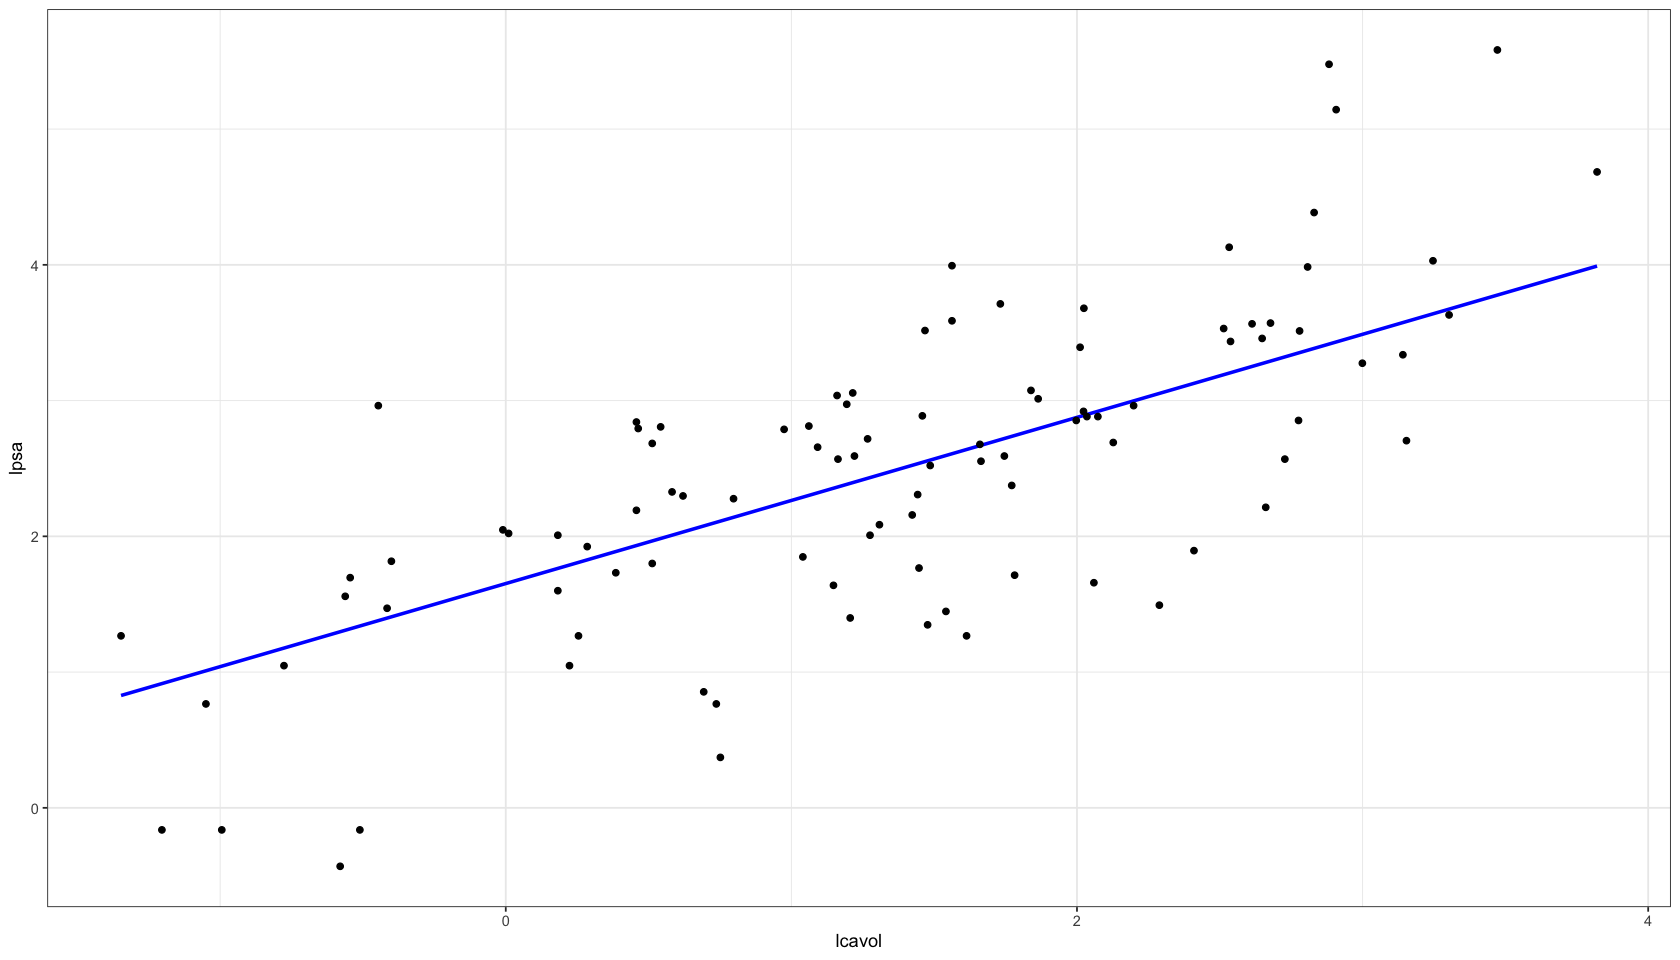

In [49]:
ggplot(data = new_data, aes(x = lcavol, y = predicted)) +
 geom_line(color = 'blue', size = 1) +
 geom_point(data = prost, aes(x = lcavol, y = lpsa)) +
 labs(y = 'lpsa', x = 'lcavol')

### Рассчитаем границы доверительной области

$$SE_\hat{y} = \sqrt{diag(X \times V_b \times X')}$$

In [51]:
# стандартные ошибки при помощи predict()
new_data$SE <- predict(M_prost_2, newdata = new_data, se.fit = TRUE)$se.fit # стандартные ошибки

# стандартные ошибки вручную
X <- model.matrix(~ lcavol + lweight + age + lbph + pgg45 , data = new_data) # модельная матрица

new_data$SE <- sqrt(diag(X %*% vcov(M_prost_2) %*% t(X))) # стандартные ошибки

new_data$upper <- new_data$predicted + 2 * new_data$SE # верхняя граница доверительной области
new_data$lower <- new_data$predicted - 2 * new_data$SE # нижняя граница доверительной области

Добавим на график границы
доверительной области.

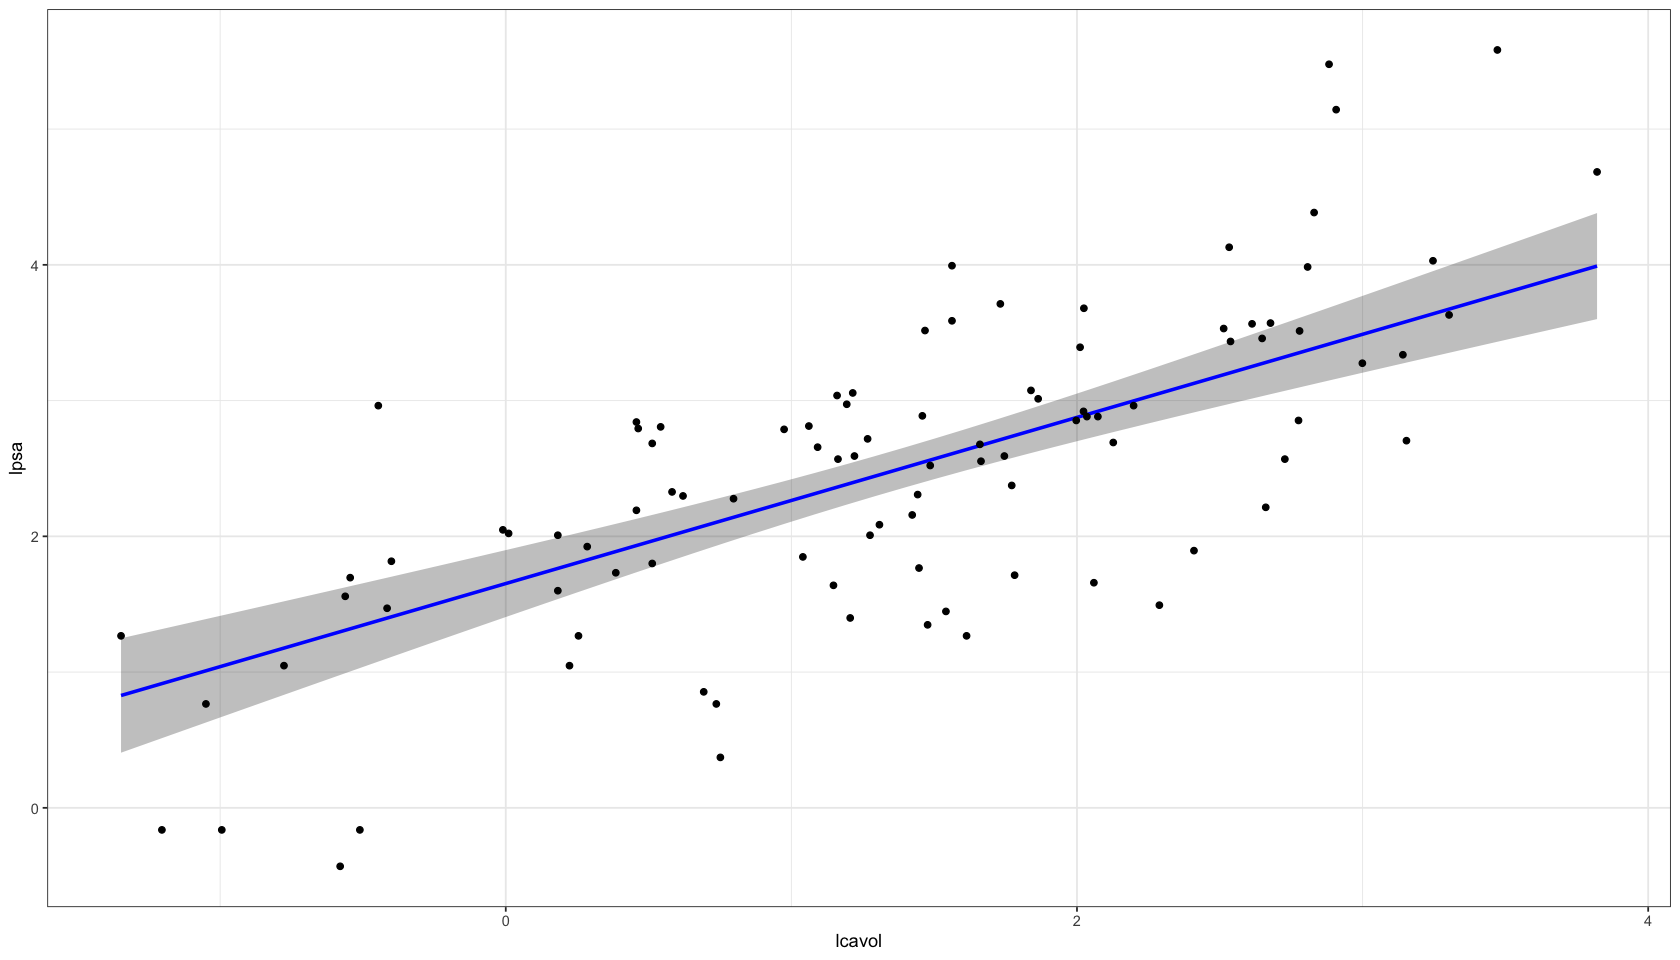

In [53]:
ggplot(data = new_data, aes(x = lcavol, y = predicted)) +
 geom_ribbon(data = new_data, aes(ymin = lower, ymax = upper), alpha = 0.3) +
 geom_line(color = 'blue', size = 1) +
 geom_point(data = prost, aes(x = lcavol, y = lpsa)) +
 labs(y = 'lpsa', x = 'lcavol')

## Визуализация модели: два предиктора

### Влияние двух предикторов: данные для визуализации

In [54]:
new_data <- expand.grid(lcavol = seq(min(prost$lcavol), max(prost$lcavol), length.out = 50),
 lweight = seq(min(prost$lweight), max(prost$lweight), length.out = 50),
 age = mean(prost$age),
 lbph = mean(prost$lbph),
 lcp = mean(prost$lcp),
 pgg45 = mean(prost$pgg45))

new_data$predicted <- predict(M_prost_2, newdata = new_data)

head(new_data)

,lcavol,lweight,age,lbph,lcp,pgg45,predicted
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,-1.3470736,2.374906,63.86598,0.1003556,-0.1793656,24.38144,-0.01259264
2,-1.2416027,2.374906,63.86598,0.1003556,-0.1793656,24.38144,0.05196330
3,-1.1361317,2.374906,63.86598,0.1003556,-0.1793656,24.38144,0.11651925
4,-1.0306608,2.374906,63.86598,0.1003556,-0.1793656,24.38144,0.18107520
5,-0.9251898,2.374906,63.86598,0.1003556,-0.1793656,24.38144,0.24563114
6,-0.8197188,2.374906,63.86598,0.1003556,-0.1793656,24.38144,0.31018709


### Визуализация влияния двух предикторов

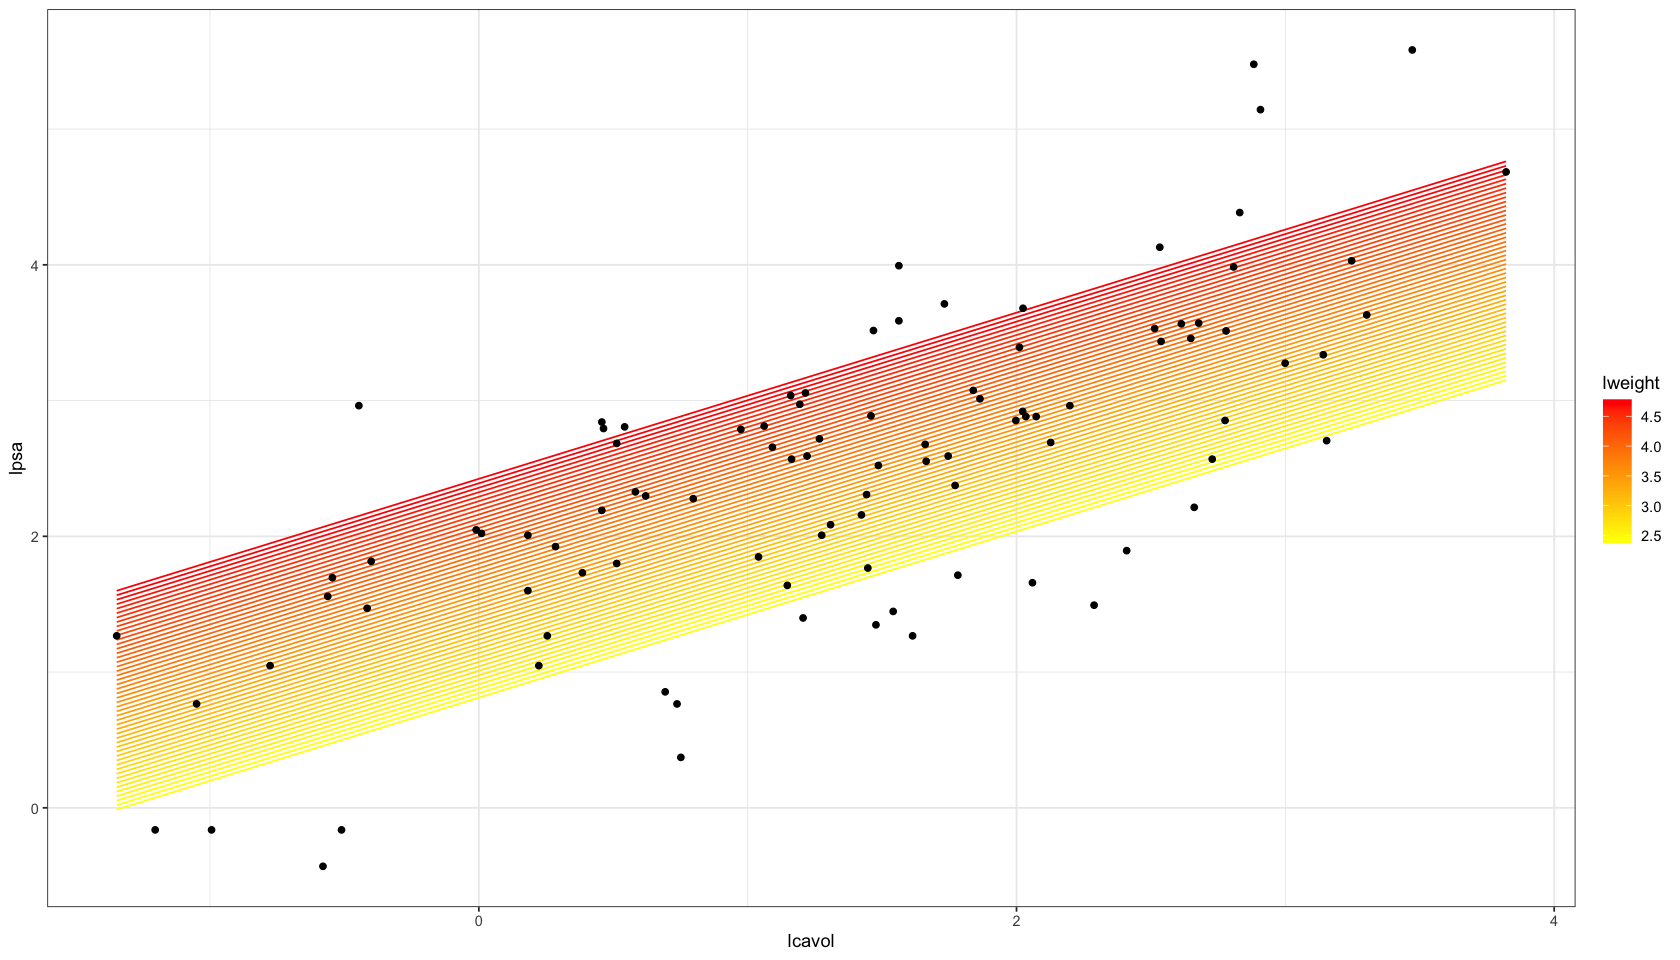

In [63]:
ggplot(new_data, aes(x = lcavol, y = predicted, group = lweight)) +
 geom_line(aes(color = lweight)) +
 geom_point(data = prost, aes(x = lcavol, y = lpsa)) +
 scale_color_continuous(high = 'red', low = 'yellow') +
 ylab('lpsa')

Преимущество – видим влияние
нескольких предикторов.

Недостаток – нельзя отобразить
доверительную область регрессии.

### Что мы знаем о множественных линейных моделях

- Часть осмысления данных необходимо провести до построения модели (разведочный анализ), часть – после того как модель построена (анализ валидности модели).
- Множественные линейные модели устроены принципиально так же, как и простая
линейная регрессия (особенно если мы смотрим на них в матричном виде)